In [106]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter('ignore')

In [2]:
fraud=pd.read_csv('/Identifying fradulent activities/Fraud.csv')

In [3]:
ip_country=pd.read_csv('/Identifying fradulent activities/IpAddress_to_Country.csv')

In [4]:
fraud.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,1,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,2,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,3,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,4,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,5,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
ip_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [6]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      151112 non-null  int64  
 1   user_id         151112 non-null  int64  
 2   signup_time     151112 non-null  object 
 3   purchase_time   151112 non-null  object 
 4   purchase_value  151112 non-null  int64  
 5   device_id       151112 non-null  object 
 6   source          151112 non-null  object 
 7   browser         151112 non-null  object 
 8   sex             151112 non-null  object 
 9   age             151112 non-null  int64  
 10  ip_address      151112 non-null  float64
 11  class           151112 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 13.8+ MB


In [7]:
ip_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Data Explore Analysis

#### Add country column to the fraud table 

In [8]:
country=[]
for ind,row in fraud.iterrows():
    tmp=ip_country[(ip_country['lower_bound_ip_address']<=row['ip_address']) & (ip_country['upper_bound_ip_address']>=row['ip_address'])]['country']
    if len(tmp)==1:
        country.append(tmp.values[0])
    else:
        country.append('NA')
fraud['country']=country
        

In [9]:
fraud.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,1,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,2,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,3,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,4,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,5,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


#### Feature engineering

1. time difference between sign-up time and purchase time 
2. device_id: if multiple user ids using the same device could be an indicator of fraudulent. 
3. ip_address: many different users having the same ip address could be an indicator of fraudulent.
4. datetime feature engineering

In [18]:
# time difference 
df=fraud.copy()
df['signup_time']=pd.to_datetime(df['signup_time'])
df['purchase_time']=pd.to_datetime(df['purchase_time'])
df['tdiff']=(df['purchase_time']-df['purchase_time'])/np.timedelta64(1, 's')

In [25]:
# number of users using the same device 
df['device_user_ct']=df.groupby('device_id')['user_id'].transform('count')

In [37]:
# number of users' using a given ip address
df['ip_ct']=df.groupby('ip_address')['user_id'].transform('count')

In [42]:
sum(df['device_user_ct']==1)/len(df)

0.8720750172057812

In [45]:
sum(df['ip_ct']==1)/len(df)

0.944908412303457

87.2% of users match one device and 94.4% users use one ip address. 

In [73]:
# day of the week and the day
df['signup_day']=df['signup_time'].dt.dayofweek
df['signup_week']=df['signup_time'].dt.week

df['purchase_day']=df['purchase_time'].dt.dayofweek
df['purchase_week']=df['purchase_time'].dt.week

In [74]:
data=df[['purchase_value','source','browser','sex','age','class','country','device_user_ct','ip_ct','signup_day','signup_week','purchase_day','purchase_week']]

In [75]:
data

,purchase_value,source,browser,sex,age,class,country,device_user_ct,ip_ct,signup_day,signup_week,purchase_day,purchase_week
0,34,SEO,Chrome,M,39,0,Japan,1,1,1,9,5,16
1,16,Ads,Chrome,F,53,0,United States,1,1,6,23,0,24
2,15,SEO,Opera,M,53,1,United States,12,8,3,1,3,1
3,44,SEO,Safari,M,41,0,NA,1,1,1,18,0,19
4,39,Ads,Safari,M,45,0,United States,1,1,1,30,2,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,43,SEO,Chrome,M,28,1,United States,2,1,1,5,6,13
151108,35,SEO,Safari,M,32,0,Netherlands,1,1,4,20,1,22
151109,40,SEO,IE,F,26,0,Japan,1,1,1,10,2,21
151110,46,SEO,Chrome,M,37,0,United States,2,1,3,28,0,37


#### Categorical encoding

In [76]:
# One hot encoding

data=pd.get_dummies(data,columns=['source','browser','sex'],drop_first=True)

In [77]:
# frequency encoding for country column 

country_freq=data['country'].value_counts(normalize=True)
data['country_ec']=data['country'].map(lambda x:country_freq[x])

In [78]:
data=data.drop(['country'],axis=1)

In [79]:
data['class'].value_counts(normalize=True)

0    0.906354
1    0.093646
Name: class, dtype: float64

The data is imbalanced. 

### Splitting data into train and test dataset

In [82]:
X=data.drop(['class'],axis=1)
y=data['class']

In [85]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,random_state=42,stratify=y)

### Balancing data with over-sampling (SMOTE)

<AxesSubplot:xlabel='class', ylabel='count'>

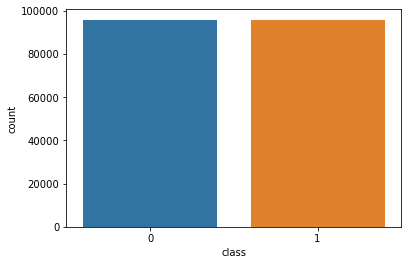

In [90]:
smo=SMOTE()
X_smo,y_smo=smo.fit_resample(X_train,y_train)
sns.countplot(y_smo)

### Logistic regression model

In [98]:
lg=LogisticRegression()
lg.fit(X_smo,y_smo)
y_pred=lg.predict(X_test)

array([1, 0, 0, ..., 0, 0, 0])

In [100]:
confusion_matrix=confusion_matrix(y_test,y_pred)
confusion_matrix

array([[36286,  4803],
       [ 1666,  2579]])

In [103]:
roc_auc_score(y_test,y_pred)

0.7453228406686843

### Random forest model

In [114]:
rf=RandomForestClassifier()
rf.fit(X_smo,y_smo)
y_pred_rf=rf.predict(X_test)

In [116]:
roc_auc_score(y_test,y_pred_rf)

0.7707778291949839

### What kinds of users are more likely to be classiﬁed as at risk?

In [121]:
imp=pd.DataFrame(rf.feature_importances_,index=X_smo.columns,columns=['importance'])

In [126]:
imp=imp.sort_values('importance',ascending=True)

<AxesSubplot:>

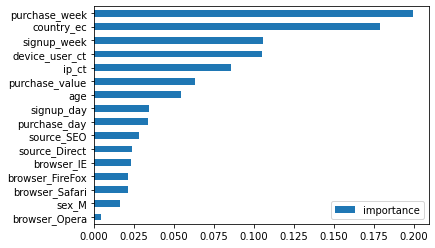

In [127]:
imp.plot(kind='barh')

### From a product perspective, how would you use this model?

If predicted fraud probability < X, the user has the normal experience (the high majority should fall here)
If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an additional verification step, like verify your phone number via a code sent by SMS or log in via Facebook.
If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user his session has been put on hold. 